# Replicating portfolios 
#### Simulating a mortgage portfolio

https://riskatwork.nl/wp-content/uploads/2019/11/RAW-MortgagePrepayments.pdf

1000 mortgages each with a notional of 1 mln EUR.
Generate them using the real evolution of interest rates over the last 30 years.

Mortgages typically have a lineair interest rate model - where the monthly prepayment is fixed, or use an annualized schema - in which interest plus prepayment makes a fixed amount per month.


### Predictive modelling for market risk in the banking book
#### Applied Operational Research in Business consulting
EY

#### Behavioral modelling in the banking book

Customers normally have the option to re-pay the mortgage earlier then the maturity / repricing data. 

In general a bank loan may not be held until maturity because:
* Customers repay the loan early (as a percentage of the loan, or fully when moving)
* Customers can default on the loan - forcing the bank to write off the loan

Growth and new business 
Customers will change there behavious towards the interest rates that they want to lock in their mortgages based on assumptions they have about the economy and especially the forward interest rates and the prices offered by the bank. 

The DNB loan level data may say something here...




In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import openpyxl
import pandas as pd
import numpy_financial as npf
import seaborn as sns
from  src.visualization import visualize
from  src.data import make_dataset

pd.set_option("display.precision", 2)

In [93]:
# initially prepayment rate and probability of default is modelled as a constant
pre_payment_rate = 0.4
pdf = 0.15
coupon_rate = 0.02 # Based on the market rates, on average 4.5%

# Growth rate of new business is a fixed percentage (with an average lifespan of 8 years - growth rate should be more then 10%)
# Maybe I can get this from the yearly statements
gr = 0.05

#### Mortagage interest development

Interest data on mortgages have been downloaded from the dutch central bank statistics site. 

https://www.dnb.nl/statistieken/data-zoeken/#/details/deposito-s-en-leningen-van-mfi-s-aan-huishoudens-rentepercentages-gecorrigeerd-voor-breuken-maand/dataset/efba2d4e-fb53-49a8-a1fe-d5ee3263e14c/resource/8d3ccc86-8396-43b8-a18b-5ba293f01c1d


In [94]:
df_i = make_dataset.get_interest_data()

2023-03-07 23:35:31.875 | INFO     | src.data.make_dataset:get_interest_data:40 - getting interest data from file 


In [95]:
df_i.tail()

,fixed_period,interest
period,,
2022-08-01,<= 1 year,2.52
2022-09-01,<= 1 year,2.68
2022-10-01,<= 1 year,3.11
2022-11-01,<= 1 year,3.36
2022-12-01,<= 1 year,3.54


In [89]:
 # Generate mortgage contracts
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import datetime 
from random import randrange
import numpy as np
from pandas.tseries.offsets import BDay

pos_date = parse('3-mar-2023')    
n = 1

# probability of 10 years contracts is 10x higher then 1 year contract
# as they can start 10 years before. 
# Devision in fixed interest period is dependend on the coupon rates

def random_date(
        start: datetime, 
        end: datetime
) -> datetime:
    """ return a random business date between start and end date """    
    delta = end-start
    date = start + datetime.timedelta(days=randrange(delta.days))    
    # shift dates to next business day if closed
    if date.weekday() >= 5:
        date = date + BDay(1)
        date = date.to_pydatetime()
    return date

category = np.random.choice(  
            a=[0, 1, 2, 3], 
            size=n, 
            p=[0.03,                    
                0.14, 
                0.23,                    
                0.60]  
            ) 
df = pd.DataFrame()
df['category'] = category
d = {0: '<= 1 year', 1:  '1>5 years', 2: '5>10 years', 3:  '> 10 years'}    
df['fixed_period'] = df['category'].map(d).astype('category')
df['fixed_period'].cat.set_categories(['<= 1 year', '1>5 years', '5>10 years', '> 10 years' ], ordered=True)
df['years'] = df['category'].map({0: 1, 1: 5,2: 10, 3: 20})
df['start_date'] = df.apply(lambda row: random_date( pos_date -
                            relativedelta(years=row.years), pos_date), axis = 1)
df['period'] = df['start_date'].to_numpy().astype('datetime64[M]')
df['principal'] = 100000    
df = df.merge(df_i.reset_index(),how = 'left', on = ['period','fixed_period'] )
df['interest'].fillna(df_i['interest'].tail(1), inplace=True)

In [96]:
principal = 300000
interest_rate = 2
years = 30
fixed_period = 10
x = make_dataset.generate_mortgage_cashflow(principal, interest_rate, years, fixed_period)
x

,Period,cashflow
0,1,50833.33
1,2,50694.44
2,3,50555.56
3,4,50416.67
4,5,50277.78
...,...,...
115,116,34861.11
116,117,34722.22
117,118,34583.33
118,119,34444.44


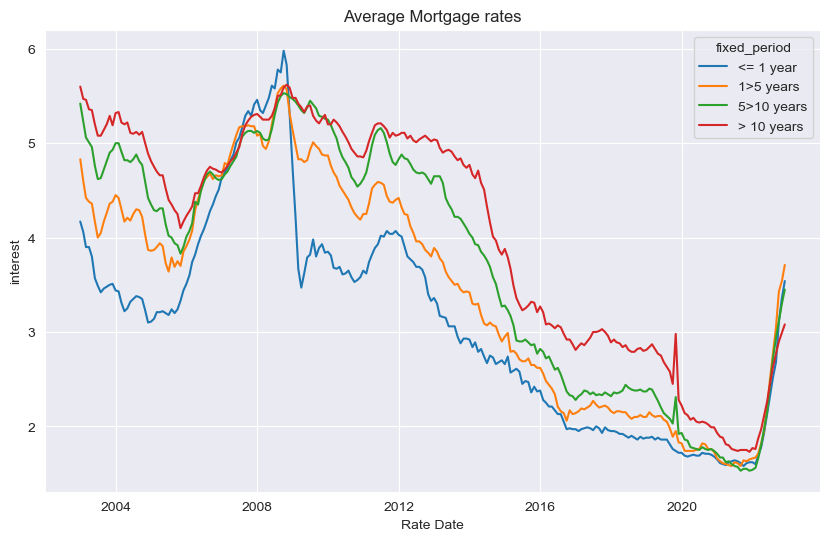

In [97]:
visualize.lineplot(
    df_i, 
    x = df_i.index, 
    x_label = 'Rate Date',
    y = 'interest',     
    hue = 'fixed_period',
    title="Average Mortgage rates" );




In [100]:
# De Volksbank Annual Report 
# initialize data of lists.

data = {'year':  [  2021,  2020,  2019,  2018,  2017,  2016,   2015,  2014,  2013,  2012,  2011 ],
        'loans': [ 50727, 50542, 50542, 50461, 50536, 48593,  49217, 52834, 53405, 49341, 51263 ] }
  
# Create DataFrame
df = pd.DataFrame(data)
df = df.sort_values(by = ['year'] )
df['growth'] = df['loans'].pct_change()
df = df.set_index('year')
df['prepayments'] =  - round((pre_payment_rate / 100) * df['loans'],4)
df['lgd']  = - round((pdf / 100) * df['loans'],0)
df['mortgages'] = round(df.loans / 200,0)
df['net_in_outflow'] = round((df['loans'].shift(-1) - ( df['loans'] + df['prepayments'] + df['lgd'] )   ) )
df.style.format(
    na_rep='',
    formatter =     
    {    
        "loans"       : "{:,.0f}",
        "growth"      : "{:0.2%}",        
        "mortgages"   : "{:,.0f}",
        "prepayments" : "{:,.0f}",    
        "lgd"         : "{:,.0f}", 
        "net_in_outflow"         : "{:,.0f}", 
    }
    
)

,loans,growth,prepayments,lgd,mortgages,net_in_outflow
year,,,,,,
2011,"51,263",,-205,-77,256,"-1,640"
2012,"49,341",-3.75%,-197,-74,247,"4,335"
2013,"53,405",8.24%,-214,-80,267,-277
2014,"52,834",-1.07%,-211,-79,264,"-3,327"
2015,"49,217",-6.85%,-197,-74,246,-353
2016,"48,593",-1.27%,-194,-73,243,"2,210"
2017,"50,536",4.00%,-202,-76,253,203
2018,"50,461",-0.15%,-202,-76,252,359
2019,"50,542",0.16%,-202,-76,253,278


In [101]:
df = make_dataset.generate_mortgage_contracts('3-3-2023', 300, df_i)
df.head()


,category,fixed_period,years,start_date,principal,period,interest
0,3,> 10 years,20,2018-07-30,100000,2018-07-01,2.81
1,2,5>10 years,10,2021-11-29,100000,2021-11-01,1.55
2,3,> 10 years,20,2007-11-23,100000,2007-11-01,5.28
3,2,5>10 years,10,2017-04-06,100000,2017-04-01,2.38
4,3,> 10 years,20,2019-11-25,100000,2019-11-01,2.98


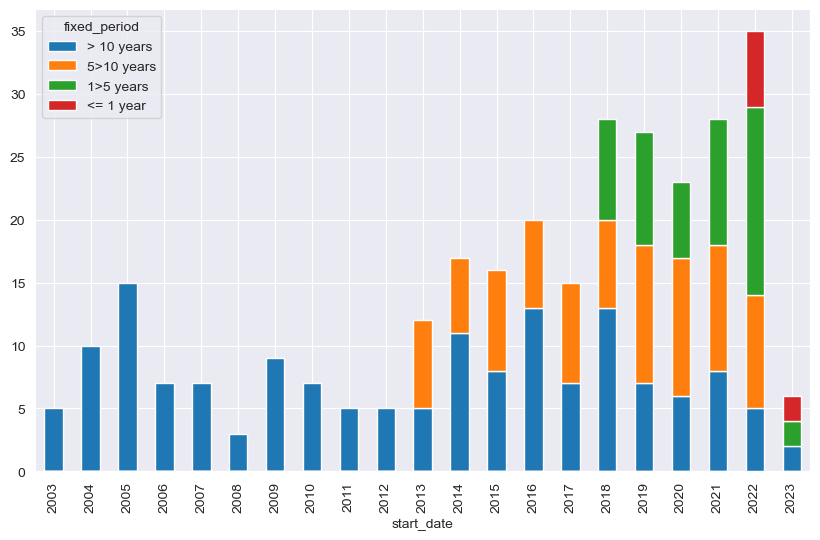

In [102]:
df.sort_values(['start_date','fixed_period']).pivot_table(index = df['start_date'].dt.year, 
               columns = ['fixed_period'], 
               values = 'principal', 
               aggfunc='count',
               sort=False).plot(kind = 'bar', stacked = True);

In [103]:
df_c = make_dataset.generate_mortgage_cashflows(df)
df_c.head()


,Period,cashflow,value_dt,contract
0,1,23694.44,2018-07-30,0
1,2,23629.40,2018-08-30,0
2,3,23564.35,2018-10-01,0
3,4,23499.31,2018-10-30,0
4,5,23434.26,2018-11-30,0


<AxesSubplot:xlabel='value_dt', ylabel='cashflow'>

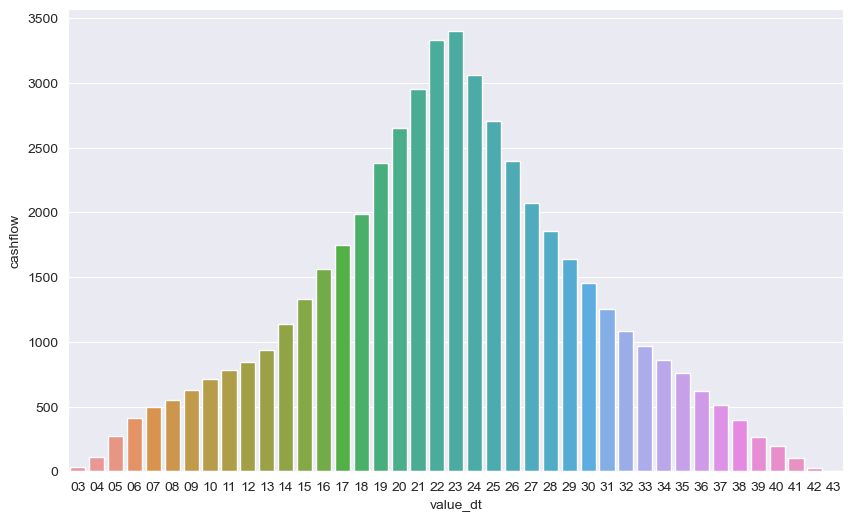

In [110]:
d = df_c[['cashflow']].groupby(df_c['value_dt'].dt.strftime('%y')).count()
sns.barplot(d,x=d.index, y = 'cashflow')

<AxesSubplot:xlabel='value_dt', ylabel='cashflow'>

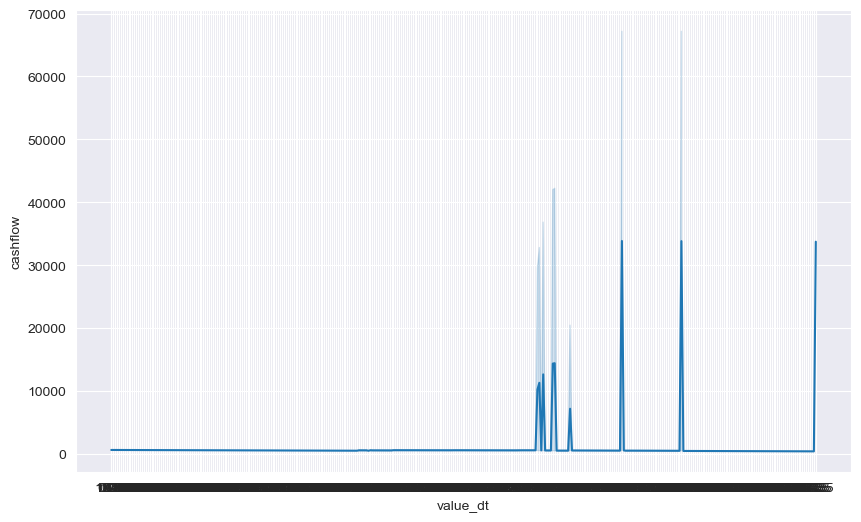

In [78]:
import seaborn as sns
import matplotlib.dates as mdates



Non Maturity Deposits

#### Core vs Non Core balances
For saving deposits a cap on the average maturity of the core deposits is set at 4.5 years. 
In general 70% - 90% of the deposits can be classied as core capital. (See guidelines BCBS)